In [23]:
from modules.models import CondGlow
from eval_utils import compare_spectrums, power_spectrum, R2
from HI_utils import load_HI_data
import numpy as np
import torch
from matplotlib import pyplot as plt
from eval_utils import save_images
from tqdm import tqdm, trange
import csv


%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
(data, conds), (test_ims, test_conds), param_names, data_funcs, cond_funcs = load_HI_data(return_funcs=True)

_, cret_func = cond_funcs
_, dret_func = data_funcs
data_inv_func = lambda x: dret_func(torch.from_numpy(x).float()).numpy()

orig_tconds = cret_func(test_conds)
orig_conds = cret_func(conds)

In [25]:
# Define network parameters and load pretrained model
cond_prior = True
params = {
    'n_channels': 1,
    'n_blocks': 6,
    'temperature': 1,
    'n_flows': 20,
    'affine': True,
    'hidden_width': 16,
    'learn_priors': True,
    'cond_features': 2,
    'start': False,
    'cond_priors': cond_prior,
    'input_size': 64,
    'cond_hidden': 8,
}
aug = True
batch_size = 64
load_ep = 1000

device = 'cpu'
model = CondGlow(**params)
model.forward(data[:10], conds[:10])

if not cond_prior:
    root_path = f'condHI_maps/{"aug_" if aug else ""}blocks={params["n_blocks"]}_flows={params["n_flows"]}_hidden={params["hidden_width"]}_batch={batch_size}_nconds=2/'
else:
    root_path = f'cond_prior/{"aug_" if aug else ""}blocks={params["n_blocks"]}_flows={params["n_flows"]}_hidden={params["hidden_width"]}_batch={batch_size}_nconds=2/'
path = root_path + 'checkpoints/'

model.load_state_dict(torch.load(path + f'model_{load_ep:04}.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [26]:
# Randomly choose sample whose parameters should be inferred
ind = 2*np.random.choice(1000, 1)[0]
img = test_ims[ind][None]

print(f'index is {ind}')
print(f'{param_names[0].strip("$")[1:]}={orig_tconds[ind][0].item():.2f}')
print(f'{param_names[1].strip("$")[1:]}={orig_tconds[ind][1].item():.2f}')

index is 1806
Omega_m=0.28
sigma_8=0.68


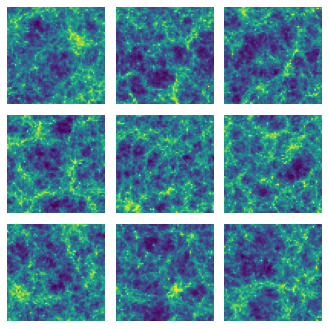

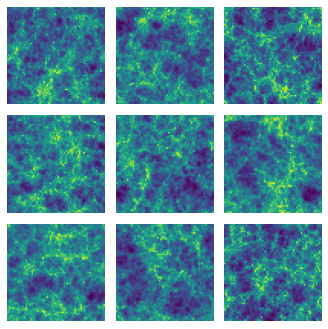

100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


In [27]:
# Sample conditional parameters uniformly for density estimation
M = 30**2

xx, yy = np.meshgrid(np.linspace(-1, 1, num=int(np.sqrt(M))),
                     np.linspace(-1, 1, num=int(np.sqrt(M))))

eval_conds = torch.concat([torch.from_numpy(xx.flatten()[:, None]).float(),
                           torch.from_numpy(yy.flatten()[:, None]).float()],
                          dim=1)

save_images(data[(ind//2)*13:(ind//2)*13+9].numpy()[:, 0], dpi=75)

c = torch.ones_like(conds[:9])*test_conds[ind][None]
samp = model.reverse(model.sample_latent(N=9), cond=c).clamp(-1, 1)
save_images(samp.detach().numpy()[:, 0], dpi=75)

batch = 128
logp = []
for i in trange(0, M, batch):
    _, lp = model.forward(img, cond=eval_conds[i:i+batch])
    logp.append(lp)
logp = torch.concat(logp)


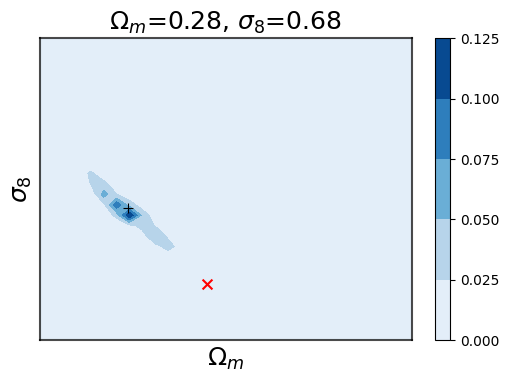

In [28]:
# Show posterior distribution

c = torch.exp(logp - torch.logsumexp(logp, dim=0)).numpy()
m = cret_func(torch.sum(eval_conds*c[:, None], dim=0).numpy()[None])[0]
c = c.reshape(int(np.sqrt(M)), int(np.sqrt(M)))

# transform xx and yy to the right space
tmp = cret_func(eval_conds).reshape((int(np.sqrt(M)), int(np.sqrt(M)), 2))

oxx, oyy = tmp[:, :, 0], tmp[:, :, 1]

fontsize = 18
plt.figure(dpi=100)
plt.contourf(oxx, oyy, c, levels=5, cmap='Blues', alpha=1)
plt.colorbar()
plt.scatter(orig_tconds[ind, 0], orig_tconds[ind, 1], 50, 'r', marker='x', linewidths=1.5)
plt.scatter(m[0], m[1], 60, 'k', marker='+', linewidths=.8)
plt.xlabel(f'{param_names[0]}', fontsize=fontsize)
plt.ylabel(f'{param_names[1]}', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
plt.title(f'{param_names[0]}={orig_tconds[ind][0]:.2f}, {param_names[1]}={orig_tconds[ind][1]:.2f}', fontsize=fontsize)
plt.box(True)
plt.grid(False)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_alpha(.7)
plt.show()

In [29]:
# Create samples for the comparison of the marginal p(x) between model and true

num_comp = 500
true = data[np.random.choice(data.shape[0], num_comp)].numpy()[:, 0]
compare_true = data[np.random.choice(data.shape[0], num_comp)].numpy()[:, 0]
alpha = .4
compare_rand = (1-alpha)*compare_true + alpha*2*(np.random.rand(*compare_true.shape)-.5)

auged_samp = int(1.25*num_comp)
c = torch.ones_like(conds[:auged_samp, :2])*conds[np.random.choice(data.shape[0], auged_samp), :2]
samps = model.reverse(model.sample_latent(N=auged_samp), cond=c).clip(-1, 1).numpy()[:, 0]
samps = samps[~np.any(np.isnan(samps), axis=(1, 2))][:num_comp]


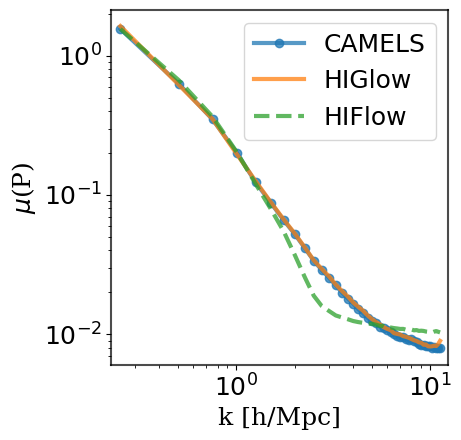

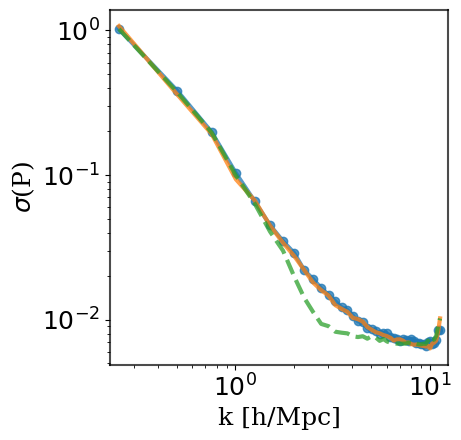

In [30]:
# Compare to HIFlow

def make_plot(plots, ylabel, legend: bool=True):
    font = {'family': 'serif',
            'color': 'black',
            'size': fontsize,
            }
    plt.figure(dpi=100, figsize=(4.7, 4.5))

    # make plots
    for (plot, label, marker, linestyle) in plots:
        plt.plot(true_freqs[0], plot, lw=3, alpha=.75, label=label, marker=marker, linestyle=linestyle)

    # add frequency label
    plt.xlabel('k [h/Mpc]', fontdict=font)
    plt.ylabel(ylabel, fontdict=font)
    plt.loglog()

    # add labels
    if legend: plt.legend(fontsize=fontsize)

    # further cosmetics
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlim([samp_freqs[0][0]-samp_freqs[0][0]/10,
              samp_freqs[0][~np.isnan(true_pows[0])][-1]+samp_freqs[0][~np.isnan(true_pows[0])][-1]/10])
    plt.tight_layout()

    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
        spine.set_alpha(.7)


HIFlow = []
with open('HIFlow_results.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for i, row in enumerate(csv_reader):
        if i > 0:
            r = [float(it) for it in row[1:-4]]
            HIFlow.append(r)

HIFlow = np.array(HIFlow)[1:]


true_inv = dret_func(torch.from_numpy(true).float()).numpy()
samp_inv = dret_func(torch.from_numpy(np.clip(samps, -.999, .999)).float()).numpy()

true_freqs, true_pows = power_spectrum(true_inv)
samp_freqs, samp_pows = power_spectrum(samp_inv)

mu_true, mu_samp = np.mean(true_pows, axis=0), np.mean(samp_pows, axis=0)
mu_true, mu_samp = HIFlow[0, 1]*mu_true/mu_true[0], HIFlow[0, 1]*mu_samp/mu_true[0]
plots = [(mu_true, 'CAMELS', 'o', '-'), (mu_samp, 'HIGlow', '', '-'), (HIFlow[:, 1], 'HIFlow', '', '--')]
ylabel = r'$\mu$(P)'
make_plot(plots, ylabel)
plt.savefig('plots/marginal_power_mu.pdf')
plt.show()

sig_true, sig_samp = np.std(true_pows, axis=0), np.std(samp_pows, axis=0)
sig_true, sig_samp = HIFlow[0, 2]*sig_true/sig_true[0], HIFlow[0, 2]*sig_samp/sig_true[0]
plots = [(sig_true, 'CAMELS', 'o', '-'), (sig_samp, 'HIGlow', '', '-'), (HIFlow[:, 2], 'HIFlow', '', '--')]
ylabel = r'$\sigma$(P)'
make_plot(plots, ylabel, legend=False)
plt.savefig('plots/marginal_power_sigma.pdf')
plt.show()

8892


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


7267


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


8177


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


2496


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


10855


/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin


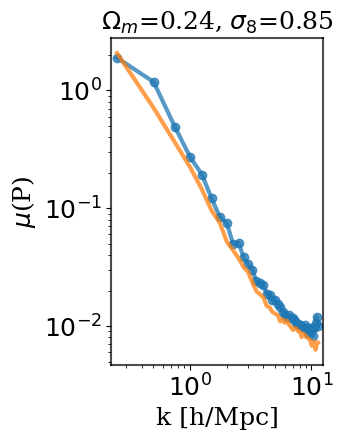

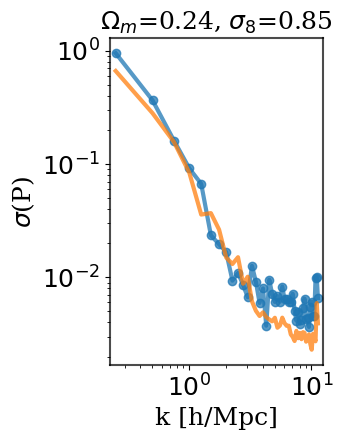

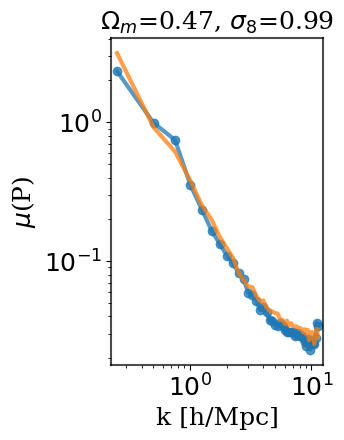

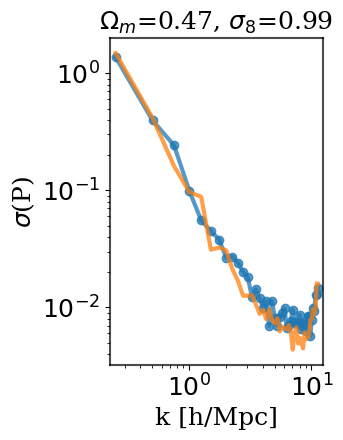

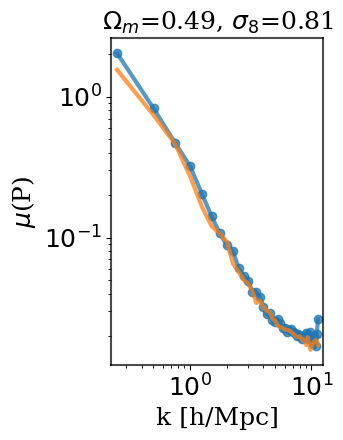

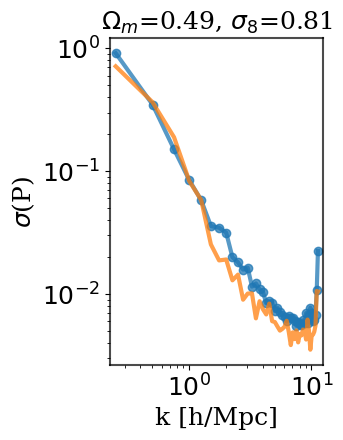

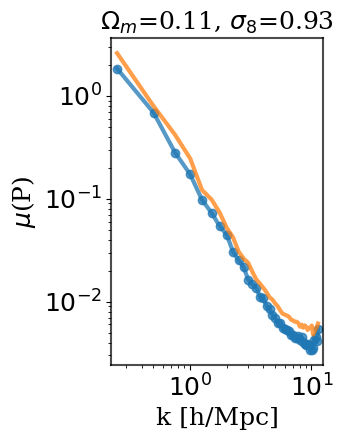

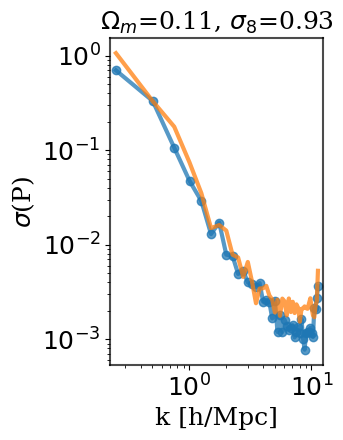

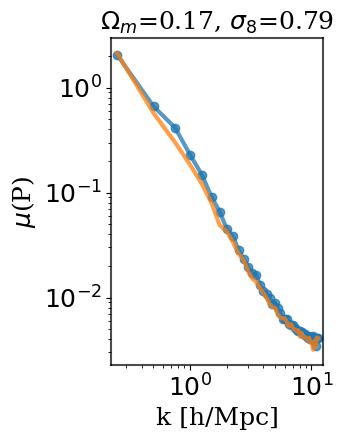

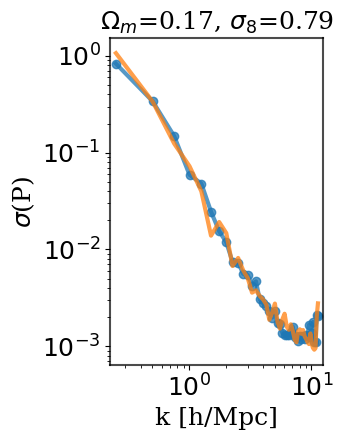

In [31]:
# Compare the power spectrums of conditionaly generated samples

# choose set of indices randomly
np.random.seed(0)
inds = np.random.choice(1000, 5)
# inds = [713, 270]
inds = [ind*13 for ind in inds]
legend = False

for ind in inds:
    print(ind)
    c = torch.ones_like(conds[:50])*conds[ind][None]
    val = orig_conds[ind]
    samps = model.reverse(model.sample_latent(N=50), cond=c).clamp(-1, 1).numpy()[:, 0]
    samps = samps[~np.any(np.isnan(samps), axis=(1,2))][:15]

    true = data[ind:ind+14].numpy()[:, 0]
    true, samps = data_inv_func(true), data_inv_func(samps)
    compare_spectrums(true, samps,
                      type='mean',
                      loglog=True,
                      title=f'{param_names[0]}={val[0]:.2f}, {param_names[1]}={val[1]:.2f}',#, ind={ind}',
                      legend=legend, small=True, save_p=f'plots/cond_pows/{ind}_mu.pdf')

    legend = False
    compare_spectrums(true, samps,
                      type='std',
                      loglog=True,
                      title=f'{param_names[0]}={val[0]:.2f}, {param_names[1]}={val[1]:.2f}',
                      legend=False, small=True, save_p=f'plots/cond_pows/{ind}_sigma.pdf')

In [32]:
# Calculate the R squares for many points in parameter space

inds = np.random.choice(1000, 100, replace=False)

Rs = []
toshow = []
pbar = tqdm(inds)
for ind in pbar:
    ind = 13*ind
    c = torch.ones_like(conds[:50])*conds[ind][None]
    val = conds[ind]
    samps = model.reverse(model.sample_latent(N=50), cond=c).numpy()[:, 0]
    samps = samps[~np.any(np.isnan(samps), axis=(1,2))]
    true = data[ind:ind+14].numpy()[:, 0]

    true, samps = data_inv_func(true), data_inv_func(samps)

    _, m_true = power_spectrum(true)
    _, m_samp = power_spectrum(samps)
    m_true, m_samp = np.array(m_true), np.array(m_samp)
    m_samp = m_samp[:, ~np.any(np.isnan(m_samp), axis=0)]
    m_true = m_true[:, ~np.any(np.isnan(m_true), axis=0)]
    r = R2(np.mean(m_true, axis=0), np.mean(m_samp, axis=0))
    Rs.append(r)
    toshow.append(ind)
    pbar.set_postfix_str(f'Omega={val[0]:.1f}, sigma={val[1]:.1f}, R2={r:.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pk[t]    += FT_box[i,j]*np.conj(FT_box[i,j])
/Users/royfriedman/Documents/Research/FlatironSummer2022/HI-generation/eval_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pk       /= count # average each bin
100%|██████████| 100/100 [03:01<00:00,  1.82s/it, Omega=-0.2, sigma=-0.6, R2=0.99]


In [33]:
srt = np.argsort(Rs)
for i in srt:
    print(f'ind {toshow[i]//13}, R2={Rs[i]}')


ind 713, R2=-0.2558444318132864
ind 141, R2=-0.08704549557567631
ind 799, R2=0.06755031631176467
ind 142, R2=0.36975977366822443
ind 270, R2=0.38774069163717473
ind 14, R2=0.39805120416637363
ind 800, R2=0.4837422022149901
ind 822, R2=0.5934842223095993
ind 557, R2=0.6434231556584138
ind 458, R2=0.6560202455242927
ind 466, R2=0.6824221151091368
ind 236, R2=0.7396334190094804
ind 864, R2=0.7487119938929764
ind 989, R2=0.7581576490534634
ind 605, R2=0.8085154472305742
ind 939, R2=0.808521516947773
ind 457, R2=0.8134891053867747
ind 231, R2=0.8251951000572129
ind 487, R2=0.8275815680621195
ind 483, R2=0.8303022193331822
ind 362, R2=0.8404652100789592
ind 530, R2=0.8405361446671892
ind 533, R2=0.8435140910954142
ind 247, R2=0.846683528532677
ind 987, R2=0.8545970470642836
ind 77, R2=0.8569964279662398
ind 311, R2=0.8658106795926022
ind 299, R2=0.867432164161874
ind 295, R2=0.8688992307109694
ind 1, R2=0.8842596662378501
ind 298, R2=0.8867409351368454
ind 991, R2=0.8935685306961662
ind 45, 

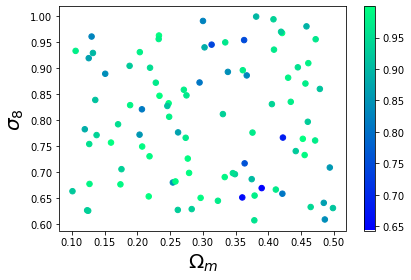

In [34]:
Rs = np.array(Rs)
inds = Rs > .6

pars = np.array(orig_conds[toshow])
plt.scatter(pars[inds, 0], pars[inds, 1], 30, c=Rs[inds], cmap='winter')
plt.xlabel(param_names[0], fontsize=20)
plt.ylabel(param_names[1], fontsize=20)
plt.colorbar()
plt.tight_layout()
plt.show()